In [1]:
# !pip install medmnist

In [2]:
# https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb

In [8]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import medmnist
from medmnist import INFO, Evaluator
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision
import torch.nn.functional as F
from tqdm import tqdm

#%aimport basic_vae
#%aimport utils
from utils import plot_real_vs_constructed 
# from basic_vae import VariationalAutoencoder

1.11.0


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision
import torch.nn.functional as F

from tqdm import tqdm


class Encoder(nn.Module):
    def __init__(self, latent_dims, channels, mode="beta_vae"):
        super(Encoder, self).__init__()
        self.channels = channels
        self.mode = mode
        # 28*28*3
        self.conv1 = nn.Conv2d(self.channels, 6, 3, stride=2)
        self.conv2 = nn.Conv2d(6, 12, 3, stride=2)   

        self.bn1 = nn.BatchNorm2d(6)
        self.bn2 = nn.BatchNorm2d(12)
        
        self.linear1 = nn.Linear(432, 256)
        # self.linear2 = nn.Linear(256, latent_dims)
        self.linear2 = nn.Linear(432, latent_dims)
        # self.linear3 = nn.Linear(256, latent_dims)
        self.linear3 = nn.Linear(432, latent_dims)
        # self.linear1 = nn.Linear(2352, 512)
        # self.linear2 = nn.Linear(512, latent_dims)
        # self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to("cuda:0")#.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.to("cuda:0")#.cuda()
        self.kl = 0

    # this is for the beta vae
    def sampling_beta(self, x):
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        # to keep the latent in the region of N(0,1)
        # self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        # self.kl = ((sigma**2 + mu**2)/2 - torch.log(sigma) - 1/2).sum()
        self.kl = 0.5 * torch.sum(torch.exp(sigma) + mu**2 - 1 - sigma)
        return z

    def forward(self, x):
        # x = torch.flatten(x, start_dim=1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = x.view(-1, 12 * 6 * 6)
        # x = F.relu(self.linear1(x))

        if self.mode == "beta_vae":
            z = self.sampling_beta(x)
        else:
            z = x
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dims, channels):
        super(Decoder, self).__init__()
        self.channels = channels
        self.conv1 = nn.ConvTranspose2d(12,6,3, stride=2)
        self.conv2 = nn.ConvTranspose2d(6,3,3, stride=2, output_padding=1)
        self.conv3 = nn.ConvTranspose2d(3,self.channels,1, stride=1)

        self.bn1 = nn.BatchNorm2d(3)
        self.bn2 = nn.BatchNorm2d(3)

        self.linear1 = nn.Linear(latent_dims, 432)
        # self.linear1 = nn.Linear(latent_dims, 256)
        self.linear2 = nn.Linear(256, 432)
        # self.linear1 = nn.Linear(latent_dims, 512)
        # self.linear2 = nn.Linear(512, 2352)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        # z = F.relu(self.linear2(z))
        z = z.reshape(-1, 12, 6, 6)
        z = self.conv1(z)
        # z = self.bn1(z)
        z = F.relu(z)
        z = self.conv2(z)
        # z = self.bn2(z)
        z = F.relu(z)
        z = self.conv3(z)
        return z.reshape((-1, self.channels, 28, 28))


class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims, mode="beta_vae", channels=2):
        super(VariationalAutoencoder, self).__init__()
        self.channels = channels
        self.mode = mode
        self.encoder = Encoder(latent_dims, self.channels, mode)
        self.decoder = Decoder(latent_dims, self.channels)
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    
    def train(self, data, epochs=5, lr=0.001, device="cpu", fast=False):
        # only for fast training
        nsamples = 100
        running_loss = 0.
        running_diff = 0.
        running_kl = 0.
        running_bce = 0.
        opt = torch.optim.Adam(self.parameters(), lr=lr)
        for epoch in range(epochs):
            i = 0
            for x, y in tqdm(data):
                if fast and i > nsamples:
                    break
                i= i + 1
                # print(x.shape)
                x = x.to(device) # GPU
    
                # for sample in x:
                opt.zero_grad()
                x_hat = self.forward(x)
                diff = ((x - x_hat)**2).sum()
                # diff = ((x - x_hat)**2).mean()
                # bce = F.binary_cross_entropy_with_logits(x_hat, x, weight=torch.Tensor([.25], device=device), reduction="sum")
                # bce = F.cross_entropy(x_hat, x, reduction="sum")
                
                loss = diff + self.encoder.kl             
                # loss = self.encoder.kl                              
                # loss = bce + 10 * self.encoder.kl + diff                        
                loss.backward()
                opt.step()

                # Gather data and report
                running_loss += loss.item()
                running_diff += diff.item()
                running_kl += self.encoder.kl.item()
                # running_bce += bce.item()
            
            last_loss = running_loss / i # loss per batch
            last_diff = running_diff / i # loss per batch
            last_kl = running_kl / i # loss per batch
            last_bce = running_bce / i # loss per batch
            print("Iteration:", epoch, "Loss:", round(last_loss,2), "Diff:", round(last_diff, 2), "KL:", round(last_kl,2), "BCE:", round(last_bce,2))
            running_loss = 0.
            running_diff = 0.
            running_kl = 0.
            running_bce = 0.        

In [10]:
# data_flag = 'pathmnist'
# data_flag = 'breastmnist'
# data_flag = 'octmnist'
# data_flag = 'chestmnist'
data_flag = 'bloodmnist'
# data_flag = 'organamnist'
# data_flag = 'tissuemnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 64
lr = 0.0001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)


Using downloaded and verified file: /Users/felix/.medmnist/bloodmnist.npz
Using downloaded and verified file: /Users/felix/.medmnist/bloodmnist.npz
Using downloaded and verified file: /Users/felix/.medmnist/bloodmnist.npz


In [11]:
train_dataset.imgs.shape

(11959, 28, 28, 3)

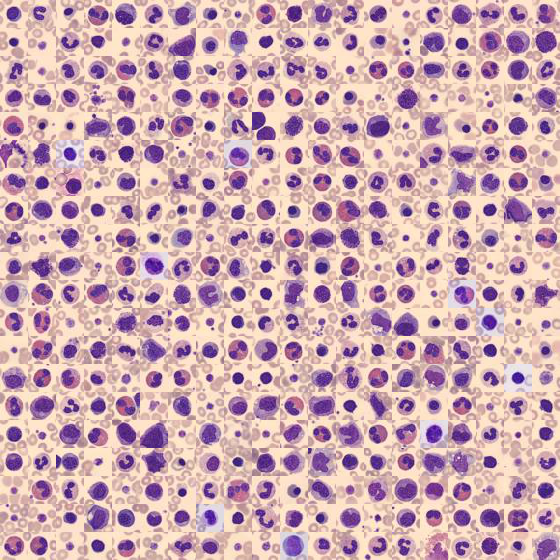

In [12]:
train_dataset.montage()

In [13]:
train_dataset.imgs.max()

255

In [19]:
from basic_vae import VariationalAutoencoder

latent_dims = 128 #hyperparameter we can optimze?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vae = VariationalAutoencoder(latent_dims, mode="beta_vae", channels=3).to(device) # GPU

vae.train(train_loader, lr=0.001, epochs=10, device=device)
# vae.train(train_loader, lr=0.0001, epochs=10, device=device)
# plot_latent(vae, train_loader)

AssertionError: Torch not compiled with CUDA enabled

In [248]:
vae.train(train_loader, lr=0.0001, epochs=10, device=device)

100%|██████████| 187/187 [00:02<00:00, 65.00it/s]


Iteration: 0 Loss: 1296.75 Diff: 1266.93 KL: 29.82 BCE: 0.0


100%|██████████| 187/187 [00:02<00:00, 70.24it/s]


Iteration: 1 Loss: 1245.46 Diff: 1217.23 KL: 28.23 BCE: 0.0


100%|██████████| 187/187 [00:02<00:00, 66.68it/s]


Iteration: 2 Loss: 1202.34 Diff: 1175.54 KL: 26.79 BCE: 0.0


100%|██████████| 187/187 [00:02<00:00, 66.15it/s]


Iteration: 3 Loss: 1162.94 Diff: 1137.37 KL: 25.57 BCE: 0.0


100%|██████████| 187/187 [00:02<00:00, 69.89it/s]


Iteration: 4 Loss: 1132.18 Diff: 1107.53 KL: 24.65 BCE: 0.0


100%|██████████| 187/187 [00:02<00:00, 65.37it/s]


Iteration: 5 Loss: 1095.57 Diff: 1071.74 KL: 23.83 BCE: 0.0


100%|██████████| 187/187 [00:02<00:00, 68.21it/s]


Iteration: 6 Loss: 1072.51 Diff: 1049.42 KL: 23.09 BCE: 0.0


100%|██████████| 187/187 [00:02<00:00, 70.57it/s]


Iteration: 7 Loss: 1051.29 Diff: 1028.8 KL: 22.49 BCE: 0.0


100%|██████████| 187/187 [00:02<00:00, 67.44it/s]


Iteration: 8 Loss: 1032.79 Diff: 1010.88 KL: 21.91 BCE: 0.0


100%|██████████| 187/187 [00:02<00:00, 69.71it/s]

Iteration: 9 Loss: 1016.21 Diff: 994.83 KL: 21.38 BCE: 0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.015443762764334679


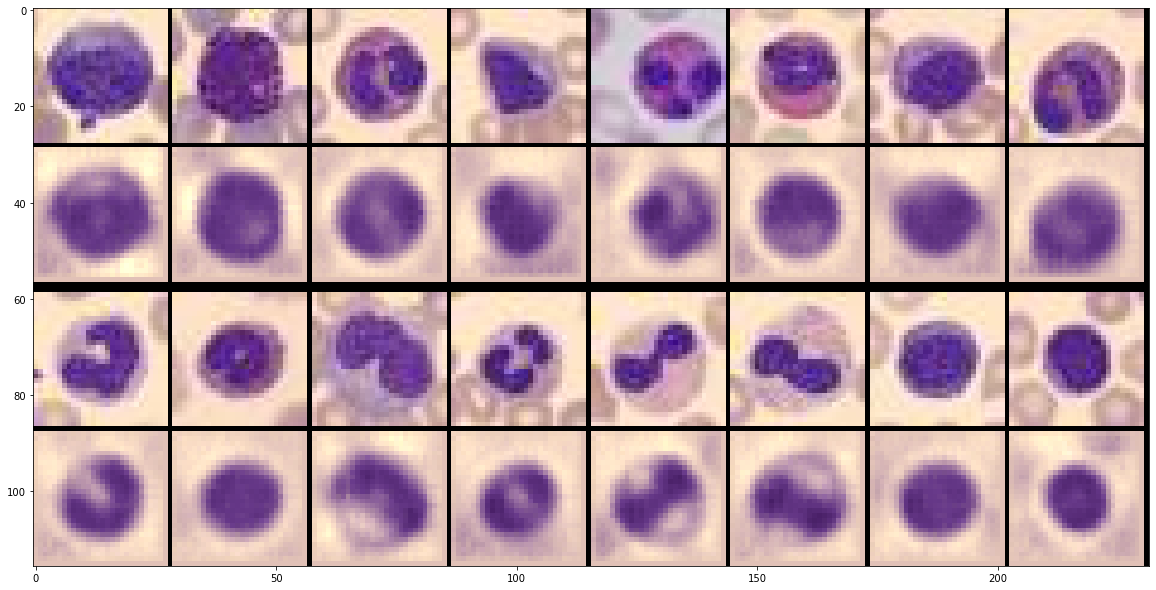

In [249]:
plot_real_vs_constructed(vae, test_dataset, device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 28, 28])


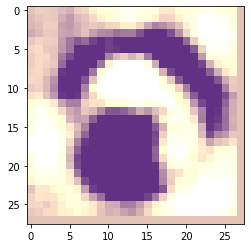

In [102]:
z = torch.randint(-1,1, (1,latent_dims), dtype=torch.float, device=device)
img = vae.decoder.forward(z)
print(img.shape)
# img = F.normalize(img)
plt.imshow(img.moveaxis(1,3).cpu().detach().numpy()[0], cmap="gray")
# plt.imshow(img.moveaxis(1, 3).cpu().detach().numpy()[0])
plt.show()

In [103]:
test_img = test_dataset[5][0][None,:,:,:].to(device)
lat = vae.encoder.forward(test_img)
img = vae.decoder.forward(lat)

[]

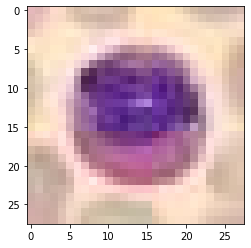

In [104]:
plt.imshow(test_img[0].moveaxis(0, 2).cpu().detach().numpy(), cmap="gray")
plt.plot()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[]

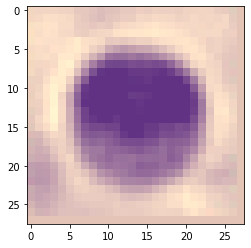

In [105]:
# img = F.normalize(img)
plt.imshow(img[0].moveaxis(0, 2).cpu().detach().numpy(), cmap="gray")
plt.plot()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


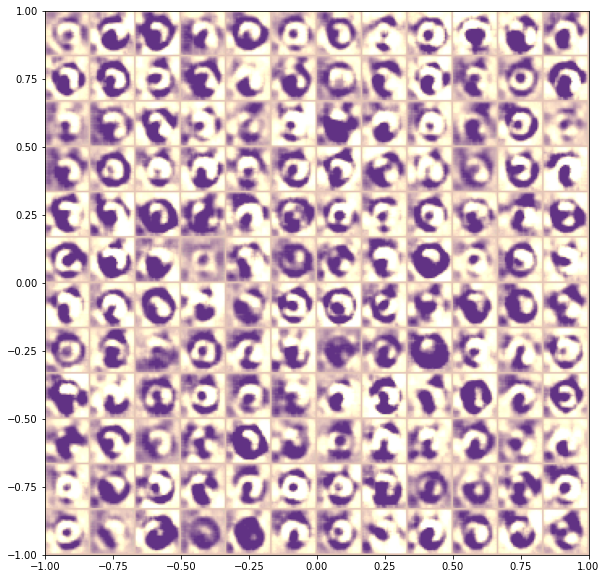

In [106]:
plot_reconstructed(vae, r0=(-1, 1), r1=(-1, 1), latent_dim=latent_dims)

# New Section

In [21]:
i = torch.randn((3, 28, 28))
cov1 = nn.Conv2d(3, 6, 3, stride=2)
cov2 = nn.Conv2d(6, 12, 3, stride=2)
m1 = nn.MaxPool2d(2)
m2 = nn.MaxUnpool2d(3)
lin1 = nn.Linear(75,108)
cov3 = nn.ConvTranspose2d(12,6,3, stride=2)#, output_padding=1)
cov4 = nn.ConvTranspose2d(6,3,3, stride=2, output_padding=1)
cov5 = nn.ConvTranspose2d(3,3,1, stride=1)#, output_padding=1)
print(i.flatten().shape, i.shape)
x = cov1(i)
x = cov2(x)
# x = m1(x)
print(x.flatten().shape, x.shape)
# x = lin1(x.flatten())
# x = x.reshape(3,6,6)
x = cov3(x)
x = cov4(x)
# x = cov4_5(x)
x = cov5(x)
# x = m2(x)
print(x.flatten().shape, x.shape)


torch.Size([2352]) torch.Size([3, 28, 28])
torch.Size([432]) torch.Size([12, 6, 6])
torch.Size([2352]) torch.Size([3, 28, 28])
